We create truth subsets for each alternative allele frequency (AAF) in each mix of the 4 CEPH/Utah grandparental genomes.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.dpi'] = 150
#matplotlib.rcParams['figure.figsize'] = [7, 5]
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joint_gt_ceph as jgc
import truth_sets_aaf as tsa
import downsize_truthset as dsts

The operations below create truth subsets for each frequency (aaf), variant type (snp or indel) and sample (mix1, mix2, mix3) and also calculate the size of each subset (nvariants)

In [3]:
def tsaaf(mix, vartype):
    bdir = '/home/attila/projects/bsm/results/2019-03-18-truth-sets/chr22'
    return(tsa.make_ts_aaf(mix=mix, vartype=vartype, tsdir=bdir + os.sep + vartype + '/truthset'))

nvariants = pd.concat([tsaaf(mix=m, vartype=v) for v in ['snp', 'indel'] for m in ['mix1', 'mix2', 'mix3']])

In [4]:
nvariants.head()

,aaf,nvariants,sample,vartype
0,2,11351,mix1,snp
1,4,15342,mix1,snp
2,6,3641,mix1,snp
3,8,18832,mix1,snp
4,10,6239,mix1,snp


The number of variants in each subset shows the following dependency on frequency (aaf), sample and variant type:

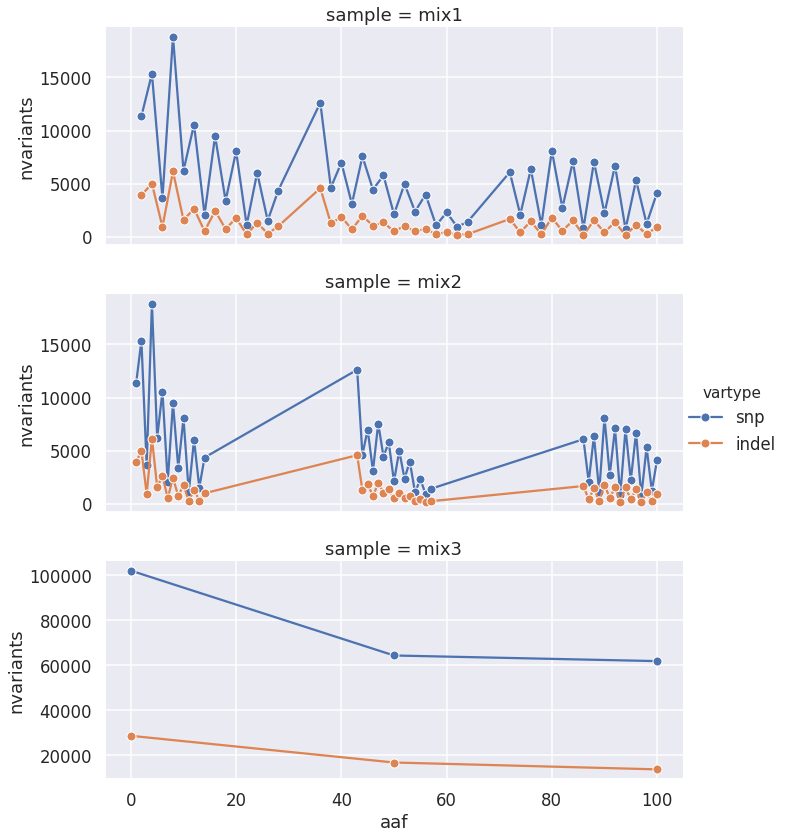

In [5]:
sns.set()
sns.set_context('talk')
fg = sns.FacetGrid(data=nvariants, row='sample', hue='vartype', sharey=False, aspect=2.5, height=4)
fg = fg.map(plt.plot, 'aaf', 'nvariants', marker='o', markeredgecolor='white', linestyle='solid')
fg = fg.add_legend()

To calculate the total number of variants by summing the number of variants over all frequencies

In [6]:
def do_sum(mix, vartype):
    a = nvariants['sample'] == mix
    b = nvariants['vartype'] == vartype
    nvars = nvariants.loc[[y[0] and y[1] for y in zip(a, b)], 'nvariants']
    return(sum(nvars))

{v: {m: do_sum(m, v) for m in ['mix1', 'mix2', 'mix3']} for v in ['snp', 'indel']}

{'indel': {'mix1': 59056, 'mix2': 59056, 'mix3': 59056},
 'snp': {'mix1': 228141, 'mix2': 228141, 'mix3': 228141}}

## Downsampling truth subsets

We don't know the number of somatic mutations in neurons.  More precisely we don't know the average number nor how it varies across cells.  Therefore we neither know how the relationship between the number of variants and alternative allele frequency (AAF) in our multinuclear/multicellular samples for bulk sequencing.

This forces us to be hypothetical, simplifying, and allow a few distinct models that describe both the total number of somatic variants as well as dependence on AAF.

I use the following simple principles
1. the total number of somatic variants is some small fraction of that of germline variants both for SNPs/SNVs and indels
1. the number of somatic variants is a linear function of AAF that
    * is either constant or decreasing
    * takes values on the domain $X$ such that $\mathrm{AAF} \in X \subset (0, 1) \setminus \{0.5\}$

### Remarks

If the function is decreasing it means that we believe that most somatic mutations arose relatively late so that they didn't have the opportunity to spread out to larger mosaic areas.

Excluding $\{0.5\}$ means that we use the simplifying assumption that if a variant has AAF it means it can only be a germline variant for which the individual is heterozygous.  Thus any call of *somatic* variants at $\mathrm{AAF}=0.5$ will be considered false even if we consider *somatic* variants at $\mathrm{AAF}=0.5$

## The models

The number for germline SNPs in an "average" human is 4.5 million based on [common knowledge](https://ghr.nlm.nih.gov/primer/genomicresearch/snp); my recent analysis shows that this is consistent with the number of germline SNPs in NA12889.  The same analysis gave more that 0.7 million indels for NA12889.

In [93]:
germ_vars = {'snp': 4.5e6, 'indel': 0.8e6}

The length of all autosomes and of chr22 is obtained from `/big/data/refgenome/GRCh37/hs37d5/hs37d5.fa.fai`.

In [92]:
hs37d5_len = {'autosomes': 2929051733, '22': 51304566}